# Distance based time series classification in aeon

Distance based classifiers use a time series specific distance function to measure the
similarity between time series. Time series distance functions are
often called elastic distances, since they compensate for possible misalignment
between series by shifting or editing the series.

 Dynamic time warping is the best
known elastic distance measure. This image
demonstrates how a warping path is found between two series
<img src="./img/dtw.png" width="400" alt="A visualisation of dynamic time warping">

We have a range of elastic distance functions in the distances module. Please see the
 [distance notebook](../distances/distances.ipynb) for more information.
 Distance functions have been mostly used with a nearest neighbour (NN) classifier,
 but you can use them with  [sklearn and aeon distances](../distances/sklearn_distances.ipynb)

<img src="./img/dtw2.png" width="400" alt="Example of warping two series to the best
alignment.">



## Load data and list distance based classifiers


In [1]:
from sklearn import metrics

from aeon.datasets import load_italy_power_demand
from aeon.registry import all_estimators

all_estimators("classifier", filter_tags={"algorithm_type": "distance"})

D:\Python\Project\Aeon\aeon\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


[('ElasticEnsemble',
  aeon.classification.distance_based._elastic_ensemble.ElasticEnsemble),
 ('KNeighborsTimeSeriesClassifier',
  aeon.classification.distance_based._time_series_neighbors.KNeighborsTimeSeriesClassifier),
 ('ProximityForest',
  aeon.classification.distance_based._proximity_forest.ProximityForest),
 ('ProximityTree',
  aeon.classification.distance_based._proximity_tree.ProximityTree)]

## Distance based classifiers
The data was derived from twelve monthly electrical power demand time series from Italy and first used in the paper "Intelligent Icons: Integrating Lite-Weight Data Mining and Visualization into GUI Operating Systems". The classification task is to distinguish days from Oct to March (inclusive) from April to September.

The dataset consists of 1096 rows in total. Each row represents a day of Italys electric power consumption. All days have a label either 1 or 2. 67 rows are used for training and the rest are for testing.

In [2]:
X_train, y_train = load_italy_power_demand(split="train", return_X_y=True)
X_test, y_test = load_italy_power_demand(split="test", return_X_y=True)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(67, 1, 24) (67,) (1029, 1, 24) (1029,)


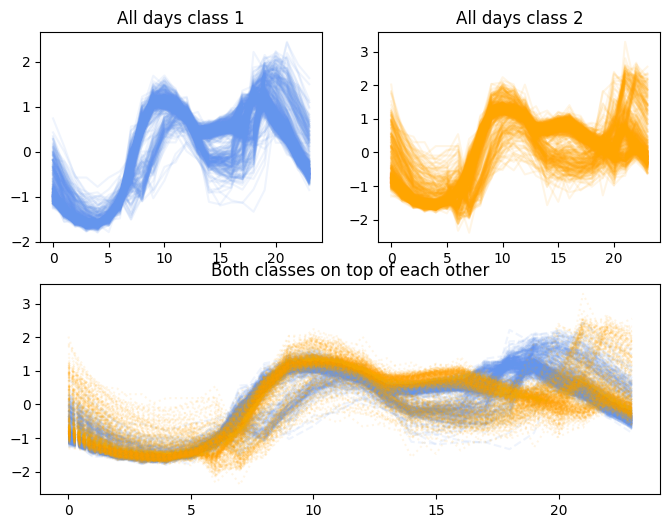

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[1, 1].axis("off")
axs[1, 0].axis("off")
ax_combined = fig.add_subplot(2, 1, (2, 3))
axs[0, 0].set_title("All days class 1")
axs[0, 1].set_title("All days class 2")
ax_combined.set_title("Both classes on top of each other")
for i in np.where(y_test == "1")[0]:
    axs[0, 0].plot(X_test[i][0], alpha=0.1, color="cornflowerblue", linestyle="solid")
    ax_combined.plot(X_test[i][0], alpha=0.1, color="cornflowerblue", linestyle="--")
for i in np.where(y_test == "2")[0]:
    axs[0, 1].plot(X_test[i][0], alpha=0.1, color="orange", linestyle="solid")
    ax_combined.plot(X_test[i][0], alpha=0.1, color="orange", linestyle=":")

In [4]:
from aeon.classification.distance_based import (
    ElasticEnsemble,
    KNeighborsTimeSeriesClassifier,
    ProximityForest,
)

## K-NN: KNeighborsTimeSeriesClassifier in aeon
k-NN is often called a lazy classifier, because there is little work done in
the fit operation. The fit operation simply stores the training data. When we want to
make a prediction for a new time series, k-NN measures the distance between the new
time series and all the series in the training data and records the class of the
closest k train series. The class labels of these nearest neighbours are used to make
 a prediction: if they are all the same label, then that is the prediction. If they
 differ, then some form of voting mechanism is required. For example, we may predict
 the most common class label amongst the nearest neighbours for the test instance.

KNeighborsTimeSeriesClassifier in aeon is configurable to use any of the distances
functions in the distance module, or it can be passed a bespoke callable. You can set
the number of neighbours and the weights. Weights are used in the prediction
process when neightbours differ in class values. By default all neighbours have an
equal vote. There is an option to weight by distance, meaning closer neighbours have
more weight in the vote.

In [5]:
knn = KNeighborsTimeSeriesClassifier(distance="msm", n_neighbors=3, weights="distance")
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)
metrics.accuracy_score(y_test, knn_preds)

0.9543245869776482

## Elastic Ensemble: ElasticEnsemble in aeon

The first algorithm to significantly out perform 1-NN DTW on the UCR data was the
Elastic Ensemble (EE) [1]. EE is a weighted ensemble of 11 1-NN classifiers with a
range of elastic distance measures. It was the best performing distance based
classifier in the bake off. Elastic distances can be slow, and EE requires cross
validation to find the weights of each classifier in the ensemble. You can configure
EE to use specified distance functions, and tell it how much.

In [6]:
ee = ElasticEnsemble(
    distance_measures=["dtw", "msm"],
    proportion_of_param_options=0.1,
    proportion_train_in_param_finding=0.3,
    proportion_train_for_test=0.5,
)
ee.fit(X_train, y_train)
ee_preds = ee.predict(X_test)
metrics.accuracy_score(y_test, ee_preds)

0.9552964042759962

### Proximity Forest

Proximity Forest [2] is a distance-based ensemble of decision trees. It is the current 
state-of-the-art distance-based classifier that creates an ensemble of decision trees, 
where the splits are based on the similarity between time series measured using various 
parameterised distance measures. The current algorithm is implemented to work for 
univariate, equal-length time-series data. 

In [7]:
forest = ProximityForest(n_trees=20, n_splitters=5, max_depth=10)
forest.fit(X_train, y_train)
forest_preds = forest.predict(X_test)
metrics.accuracy_score(y_test, forest_preds)

0.9582118561710399

## Performance on the UCR univariate datasets
You can find the dictionary based classifiers as follows. Note we do not have a
Proximity Forest implementation in aeon yet, but we do have the results

In [8]:
from aeon.registry import all_estimators

est = ["ElasticEnsemble", "KNeighborsTimeSeriesClassifier", "ProximityForest"]
for c in est:
    print(c)

ElasticEnsemble
KNeighborsTimeSeriesClassifier
ProximityForest


In [9]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = [t.replace("Classifier", "") for t in est]
names.append(
    "PF"
)  # Results from Java implementation, as are the ElasticEnsemble results

results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 4)

D:\Python\Project\Aeon\aeon\aeon\visualisation\results\_critical_difference.py:217: UserWarning: Estimators PF and ProximityForest have the same performanceon all datasets. This may cause problems when forming cliques.
  p_values = wilcoxon_test(ordered_scores, ordered_labels, lower_better)


(<Figure size 600x230 with 1 Axes>, <Axes: >)

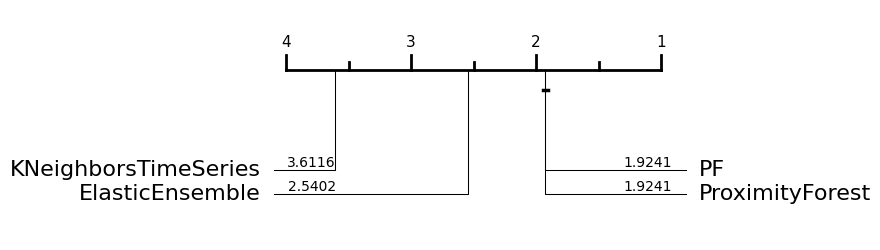

In [10]:
from aeon.visualisation import plot_boxplot_median, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

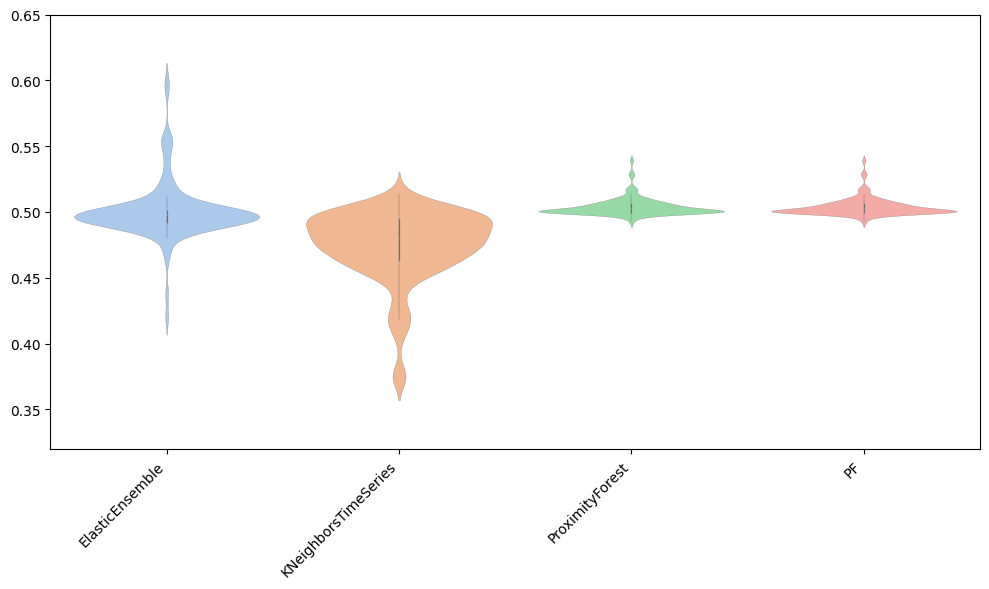

In [11]:
plot_boxplot_median(results, names)

## References

[1] Lines J, Bagnall A (2015) Time series classification with ensembles of elastic
distance measures. Data Mining and Knowledge Discovery 29:565–592

[2] Lucas et al. (2019) Proximity Forest: an effective and scalable distance-based
classifier. Data Mining and Knowledge Discovery 33: 607--635 https://arxiv.org/abs/1808.10594

